## Week 6 Homework

---

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import uniform
from scipy.special import gammaln
import pymc as pm
import arviz as az

### Q1: Let's start having some *real* fun...

We previously considered the normal-gamma specification 

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize 
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to smaple from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*

---

In [2]:
sns.set(style="darkgrid")
np.random.seed(123)

### Data generation for the location-scale-t model ###
n = 100
true_mu = 0.0
true_sigma2 = 1.0
true_nu = 5

# Generate synthetic data: x = mu + sqrt(sigma2)*T_nu
x_data = true_mu + np.sqrt(true_sigma2) * np.random.standard_t(true_nu, size=n)

### Prior hyperparameters ###
mu0 = 0.0
tau0 = 1.0
sigma0_sq = 1.0  # for the half-normal on sigma^2
# nu has a discrete uniform prior on {1,...,100}

### Sampler settings ###
iterations = 10000
burn_in = 2000
samples = np.zeros((iterations, 3))   # columns: 0: mu, 1: sigma^2, 2: nu

# Initialize parameters (starting values)
mu_current = np.mean(x_data)
sigma2_current = np.var(x_data)
nu_current = 10  # an arbitrary starting value (must be in 1,...,100)

# Tuning parameters for proposals
proposal_std_mu = 0.5
proposal_std_log_sigma2 = 0.1  # proposal on log-scale for sigma^2

# Counters for acceptance rates
accept_mu = 0
accept_sigma2 = 0
accept_nu = 0

In [3]:
### Metropolis-within-Gibbs sampler ###
for it in range(iterations):
    #### Update mu ####
    mu_proposal = np.random.normal(mu_current, proposal_std_mu)
    
    # Compute log-likelihood for current and proposed mu 
    # (note: sigma^2 and nu are kept fixed here)
    ll_current = n*(gammaln((nu_current+1)/2) - gammaln(nu_current/2) - 0.5*np.log(np.pi*nu_current*sigma2_current)) \
                 - ((nu_current+1)/2)*np.sum(np.log(1 + ((x_data - mu_current)**2)/(nu_current*sigma2_current)))
    ll_proposal = n*(gammaln((nu_current+1)/2) - gammaln(nu_current/2) - 0.5*np.log(np.pi*nu_current*sigma2_current)) \
                  - ((nu_current+1)/2)*np.sum(np.log(1 + ((x_data - mu_proposal)**2)/(nu_current*sigma2_current)))
    
    # Log prior for mu (Normal(mu0, 1/tau0))
    lp_mu_current = 0.5*np.log(tau0/(2*np.pi)) - 0.5*tau0*(mu_current - mu0)**2
    lp_mu_proposal = 0.5*np.log(tau0/(2*np.pi)) - 0.5*tau0*(mu_proposal - mu0)**2
    
    # The priors for sigma^2 and nu remain constant in this update:
    # For sigma^2: half-normal density (for sigma2 > 0)
    lp_sigma2 = 0.5*np.log(2/(np.pi*sigma0_sq)) - (sigma2_current**2)/(2*sigma0_sq)
    # For nu: discrete uniform on {1,...,100}
    lp_nu = -np.log(100)
    
    log_post_current = ll_current + lp_mu_current + lp_sigma2 + lp_nu
    log_post_proposal = ll_proposal + lp_mu_proposal + lp_sigma2 + lp_nu
    log_alpha = log_post_proposal - log_post_current
    
    if np.log(uniform.rvs()) < log_alpha:
        mu_current = mu_proposal
        accept_mu += 1

    #### Update sigma^2 (using a log-scale proposal) ####
    log_sigma2_current = np.log(sigma2_current)
    log_sigma2_proposal = np.random.normal(log_sigma2_current, proposal_std_log_sigma2)
    sigma2_proposal = np.exp(log_sigma2_proposal)
    
    # Re-compute log-likelihood (mu and nu fixed)
    ll_current = n*(gammaln((nu_current+1)/2) - gammaln(nu_current/2) - 0.5*np.log(np.pi*nu_current*sigma2_current)) \
                 - ((nu_current+1)/2)*np.sum(np.log(1 + ((x_data - mu_current)**2)/(nu_current*sigma2_current)))
    ll_proposal = n*(gammaln((nu_current+1)/2) - gammaln(nu_current/2) - 0.5*np.log(np.pi*nu_current*sigma2_proposal)) \
                  - ((nu_current+1)/2)*np.sum(np.log(1 + ((x_data - mu_current)**2)/(nu_current*sigma2_proposal)))
    
    # Log prior for sigma^2 (half-normal)
    lp_sigma2_current = 0.5*np.log(2/(np.pi*sigma0_sq)) - (sigma2_current**2)/(2*sigma0_sq)
    lp_sigma2_proposal = 0.5*np.log(2/(np.pi*sigma0_sq)) - (sigma2_proposal**2)/(2*sigma0_sq)
    
    # mu and nu priors are unchanged in this update
    log_post_current = ll_current + lp_mu_current + lp_sigma2_current + lp_nu
    log_post_proposal = ll_proposal + lp_mu_current + lp_sigma2_proposal + lp_nu
    
    # Jacobian correction for the log transformation: add log(sigma2_proposal) - log(sigma2_current)
    log_alpha = log_post_proposal - log_post_current + np.log(sigma2_proposal) - np.log(sigma2_current)
    
    if np.log(uniform.rvs()) < log_alpha:
        sigma2_current = sigma2_proposal
        accept_sigma2 += 1

    #### Update nu (discrete update by proposing a neighboring integer) ####
    if nu_current == 1:
        nu_proposal = nu_current + 1
    elif nu_current == 100:
        nu_proposal = nu_current - 1
    else:
        nu_proposal = nu_current + np.random.choice([-1, 1])
    
    # Compute log-likelihood for current and proposed nu (with fixed mu and sigma^2)
    ll_current = n*(gammaln((nu_current+1)/2) - gammaln(nu_current/2) - 0.5*np.log(np.pi*nu_current*sigma2_current)) \
                 - ((nu_current+1)/2)*np.sum(np.log(1 + ((x_data - mu_current)**2)/(nu_current*sigma2_current)))
    ll_proposal = n*(gammaln((nu_proposal+1)/2) - gammaln(nu_proposal/2) - 0.5*np.log(np.pi*nu_proposal*sigma2_current)) \
                  - ((nu_proposal+1)/2)*np.sum(np.log(1 + ((x_data - mu_current)**2)/(nu_proposal*sigma2_current)))
    
    # Prior for nu: discrete uniform on {1,...,100} (log-prior = -log(100)) if valid, else -inf
    if nu_proposal in range(1,101):
        lp_nu_proposal = -np.log(100)
    else:
        lp_nu_proposal = -np.inf
        
    log_post_current = ll_current + lp_mu_current + lp_sigma2 + lp_nu
    log_post_proposal = ll_proposal + lp_mu_current + lp_sigma2 + lp_nu_proposal
    log_alpha = log_post_proposal - log_post_current
    
    if np.log(uniform.rvs()) < log_alpha:
        nu_current = nu_proposal
        accept_nu += 1

    # Save current samples
    samples[it, 0] = mu_current
    samples[it, 1] = sigma2_current
    samples[it, 2] = nu_current

Acceptance rates:
mu:       0.2798
sigma^2:  0.8218
nu:       0.7


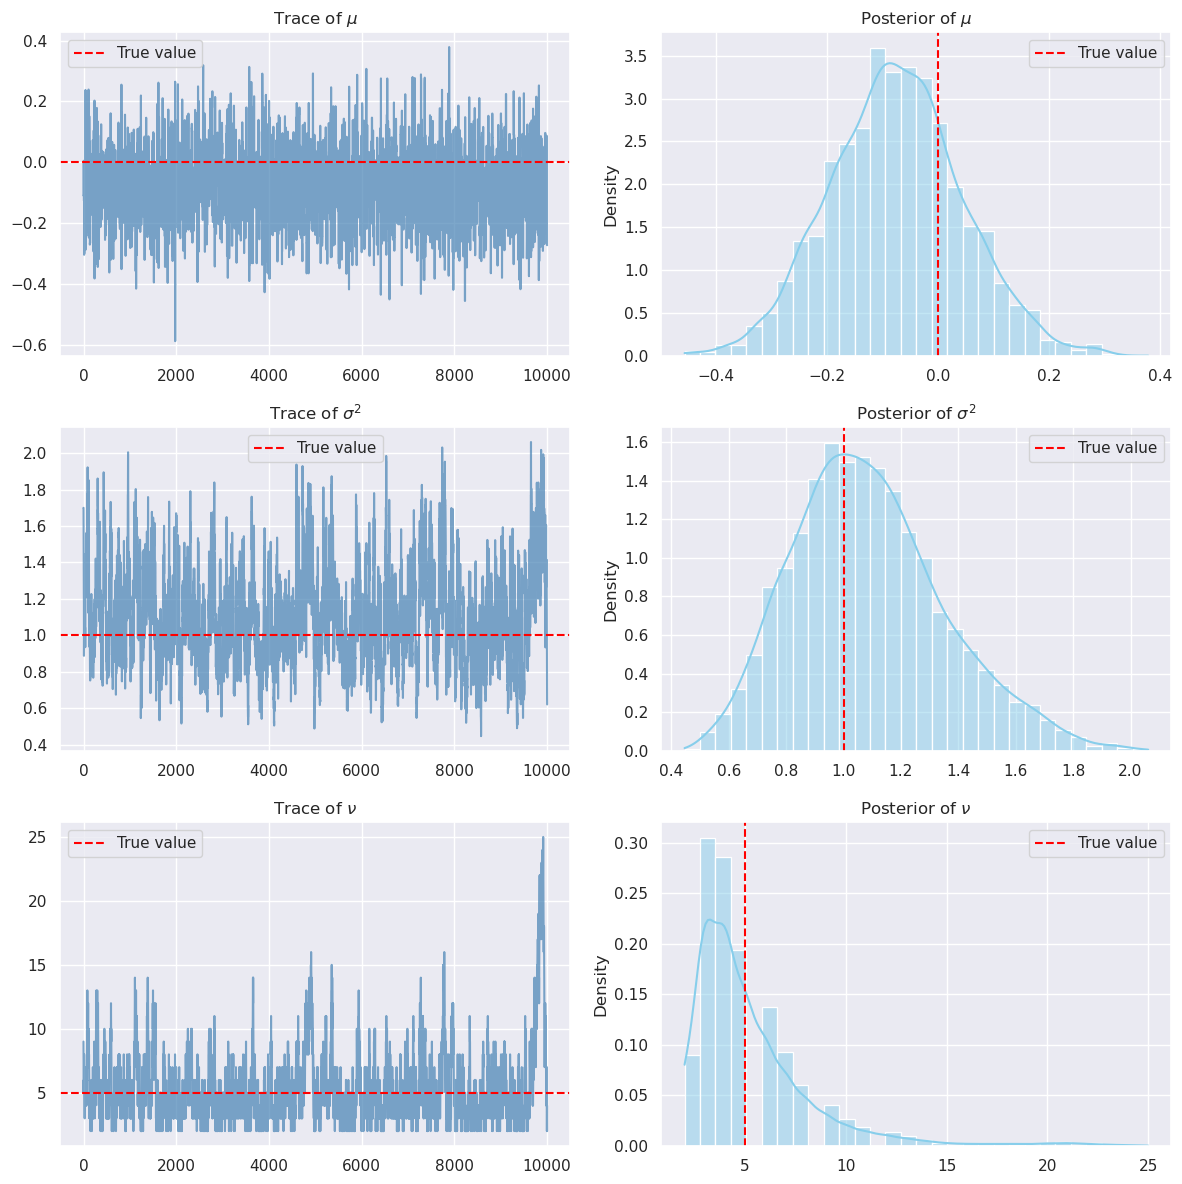

In [4]:
# Print acceptance rates
print("Acceptance rates:")
print("mu:      ", accept_mu/iterations)
print("sigma^2: ", accept_sigma2/iterations)
print("nu:      ", accept_nu/iterations)

# Discard burn-in
post_samples = samples[burn_in:, :]

### Visualizations ###

# Create a 3x2 figure: for each parameter, show a trace plot (left) and a posterior histogram (right)
param_names = [r'$\mu$', r'$\sigma^2$', r'$\nu$']
true_vals = [true_mu, true_sigma2, true_nu]
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
for i in range(3):
    # Trace plot for parameter i
    ax[i, 0].plot(samples[:, i], color='steelblue', alpha=0.7)
    ax[i, 0].set_title("Trace of " + param_names[i])
    ax[i, 0].axhline(true_vals[i], color='red', linestyle='--', label='True value')
    ax[i, 0].legend()
    
    # Histogram (with KDE) for the posterior of parameter i
    sns.histplot(post_samples[:, i], kde=True, ax=ax[i, 1], stat="density", bins=30, color="skyblue")
    ax[i, 1].set_title("Posterior of " + param_names[i])
    ax[i, 1].axvline(true_vals[i], color='red', linestyle='--', label='True value')
    ax[i, 1].legend()
plt.tight_layout()
plt.show()

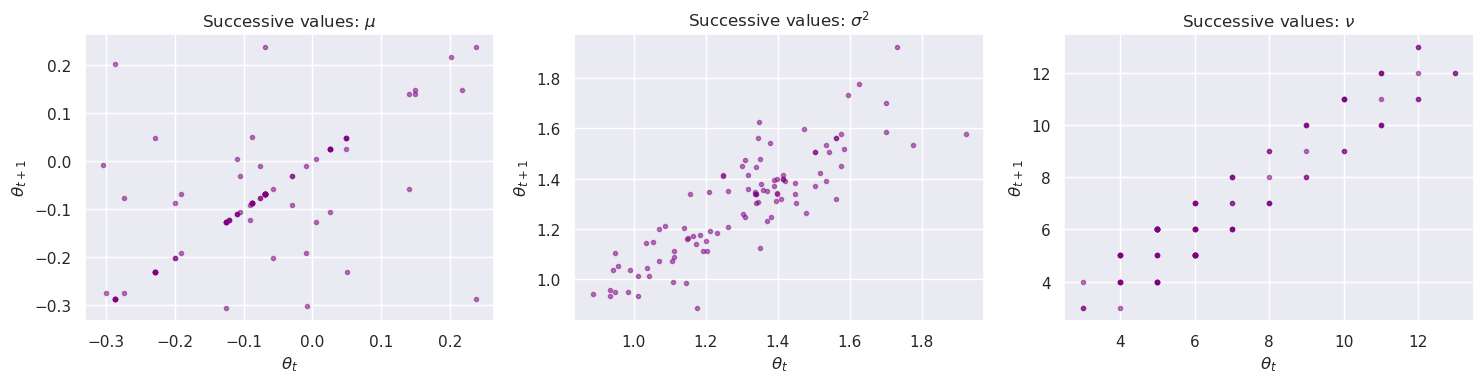

In [5]:
# Scatter plots: plot successive samples (for the first 100 iterations)
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for i in range(3):
    ax[i].plot(samples[:100, i], samples[1:101, i], '.', alpha=0.5, color='purple')
    ax[i].set_xlabel(r"$\theta_t$")
    ax[i].set_ylabel(r"$\theta_{t+1}$")
    ax[i].set_title("Successive values: " + param_names[i])
plt.tight_layout()
plt.show()

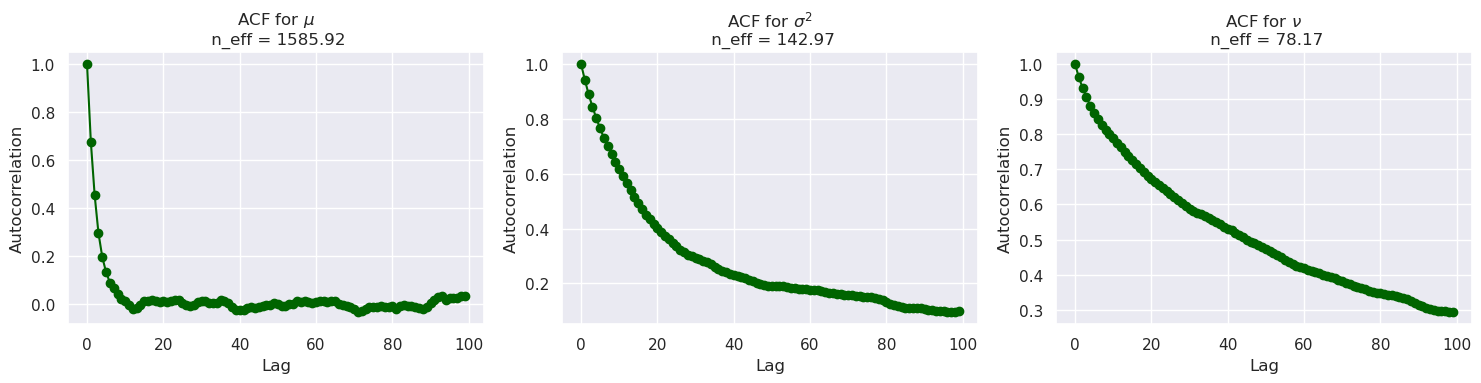

In [6]:
# Autocorrelation plots for each parameter (using post burn-in samples)
max_lag = 100
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for i in range(3):
    autocorr = np.ones(max_lag)
    for lag in range(1, max_lag):
        autocorr[lag] = np.corrcoef(post_samples[:-lag, i], post_samples[lag:, i])[0, 1]
    # Estimate effective sample size
    n_eff = len(post_samples) / (1 + 2 * np.sum(autocorr[1:]))
    ax[i].plot(np.arange(max_lag), autocorr, marker='o', color='darkgreen')
    ax[i].set_title("ACF for " + param_names[i] + f"\n n_eff = {n_eff:.2f}")
    ax[i].set_xlabel("Lag")
    ax[i].set_ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

### Q2: explore the role of sample size in providing inference for the degrees of freedom parameter $\nu$

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*

---

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.



Summary for sample size n = 50:
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu      0.165   0.209  -0.242    0.539      0.003    0.002    4276.0   
sigma   1.421   0.198   1.044    1.793      0.006    0.004    1254.0   
nu     36.278  29.316   2.000   91.000      1.175    0.832     565.0   

       ess_tail  r_hat  
mu       4100.0   1.00  
sigma    1567.0   1.00  
nu        668.0   1.01  


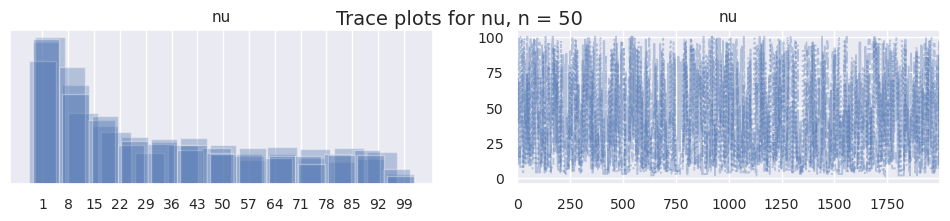

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



Summary for sample size n = 100:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu    -0.307  0.110  -0.506   -0.091      0.002    0.001    3834.0    4365.0   
sigma  0.994  0.129   0.751    1.236      0.005    0.004     658.0    1381.0   
nu     7.781  8.567   2.000   19.000      0.478    0.339     376.0     427.0   

       r_hat  
mu      1.00  
sigma   1.00  
nu      1.01  


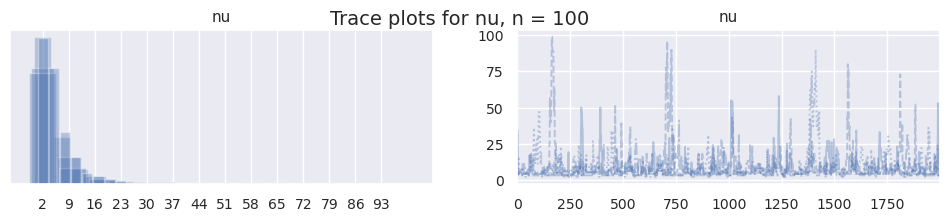

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details



Summary for sample size n = 500:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     0.015  0.052  -0.079    0.115      0.001    0.001    4157.0    4130.0   
sigma  1.013  0.054   0.916    1.120      0.002    0.001     889.0    1894.0   
nu     7.280  2.550   4.000   12.000      0.105    0.074     511.0     524.0   

       r_hat  
mu      1.00  
sigma   1.01  
nu      1.01  


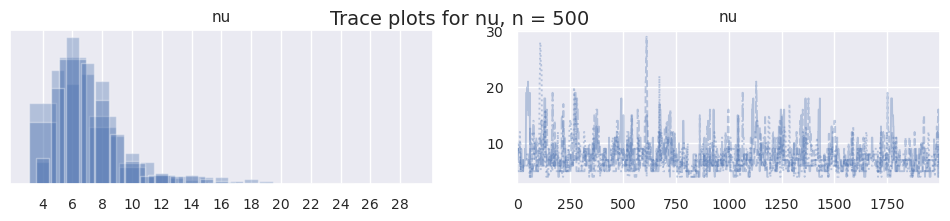

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.



Summary for sample size n = 1000:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     0.050  0.035  -0.014    0.118      0.000    0.000    5453.0    4974.0   
sigma  0.974  0.038   0.899    1.044      0.001    0.001    1185.0    2267.0   
nu     5.267  0.917   4.000    7.000      0.034    0.024     727.0     764.0   

       r_hat  
mu       1.0  
sigma    1.0  
nu       1.0  


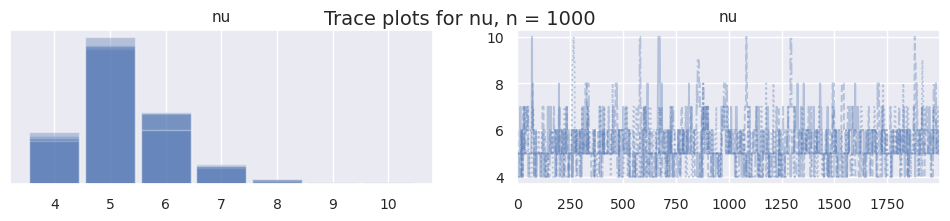

In [8]:
sns.set(style="darkgrid")
np.random.seed(123)

# True parameters for the synthetic data
true_mu = 0.0
true_sigma = 1.0  # PyMC’s StudentT uses sigma (std dev) rather than sigma^2
true_nu = 5

# Different sample sizes to explore the inference on nu
sample_sizes = [50, 100, 500, 1000]

# Dictionary to hold traces for each sample size
traces = {}

# Loop over different sample sizes
for n in sample_sizes:
    # Generate synthetic data from a Student's t distribution
    data = true_mu + true_sigma * np.random.standard_t(true_nu, size=n)
    
    # Build the PyMC model
    with pm.Model() as model:
        # Prior for mu: Normal(mu0, 1/sqrt(tau0)); here we use sigma=1 for simplicity
        mu = pm.Normal("mu", mu=0, sigma=1)
        # Prior for sigma: HalfNormal; note that our specification had a half-normal on sigma^2,
        # but we use a half-normal for sigma (standard deviation) as is typical in PyMC.
        sigma = pm.HalfNormal("sigma", sigma=1)
        # Prior for nu: DiscreteUniform between 1 and 100
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)
        # Likelihood: StudentT with parameters (nu, mu, sigma)
        likelihood = pm.StudentT("likelihood", nu=nu, mu=mu, sigma=sigma, observed=data)
        
        # Sample from the posterior. PyMC will use NUTS for continuous vars and Metropolis for nu.
        trace = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True, progressbar=False)
    
    traces[n] = trace
    
    # Print summary statistics for this sample size
    print(f"\nSummary for sample size n = {n}:")
    print(az.summary(trace, var_names=["mu", "sigma", "nu"]))
    
    # Trace plot for nu
    az.plot_trace(trace, var_names=["nu"])
    plt.suptitle(f"Trace plots for nu, n = {n}", fontsize=14)
    plt.show()

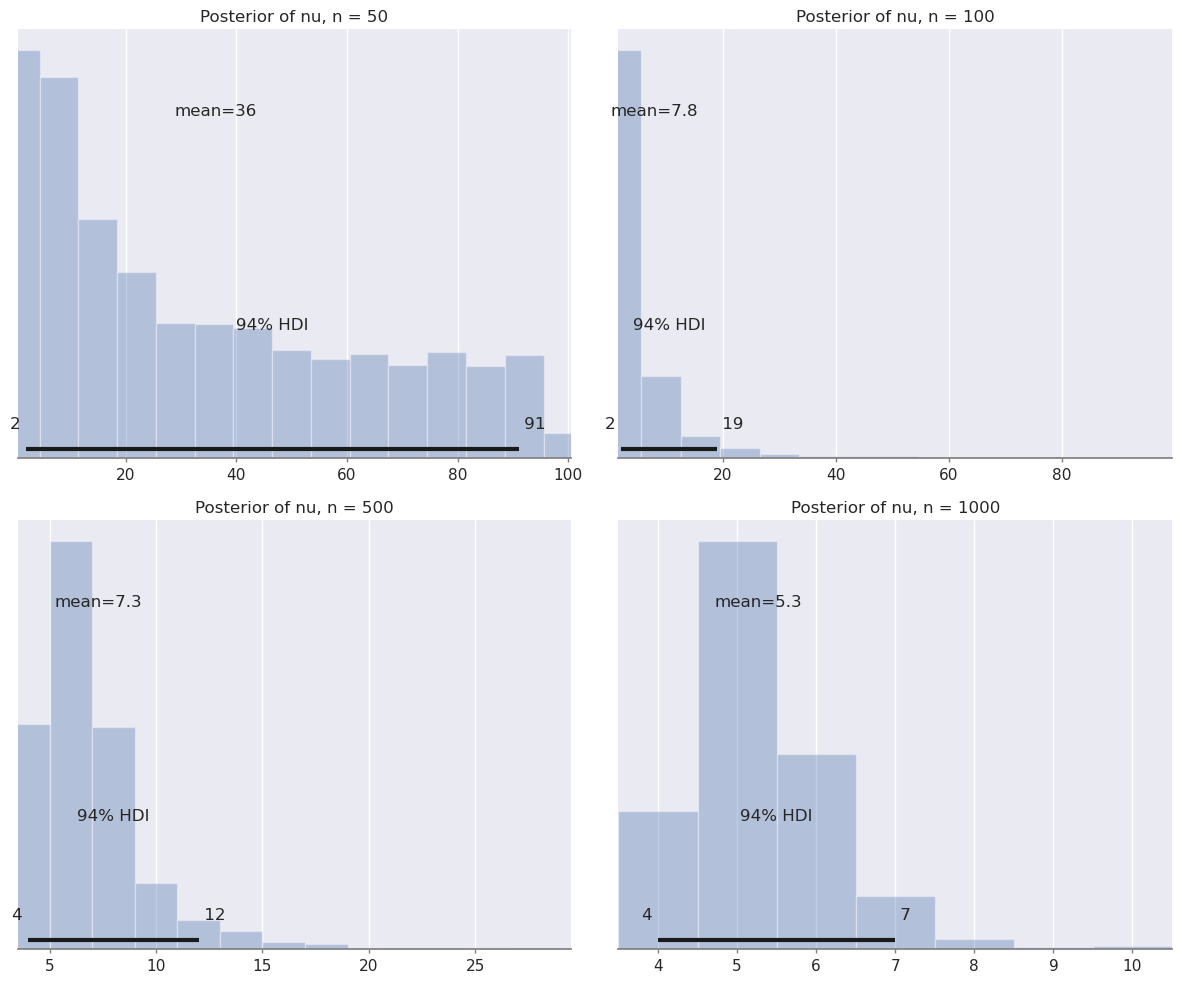

In [9]:
# Plot posterior distributions for nu for all sample sizes in one figure
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax = ax.flatten()
for i, n in enumerate(sample_sizes):
    az.plot_posterior(traces[n], var_names=["nu"], ax=ax[i])
    ax[i].set_title(f"Posterior of nu, n = {n}", fontsize=12)
plt.tight_layout()
plt.show()

We conducted a Bayesian inference on the degrees of freedom parameter \\(\nu\\) in a Student's t-distribution using PyMC, focusing on how varying sample sizes impact the accuracy and precision of the inferred \\(\nu\\).

### Experimental Setup

- **True Parameters**:
  - \\(\mu_{\text{true}} = 0\\)
  - \\(\sigma_{\text{true}} = 1.0\\)
  - \\(\nu_{\text{true}} = 5\\)

- **Sample Sizes Explored**:
  - \\(n = [50, 100, 500, 1000]\\)

- **Bayesian Model**:
  - Prior for \\(\nu\\): Discrete Uniform over \\([1, 100]\\)
  - \\(\mu\\) and \\(\sigma\\) were fixed at their true values to focus the inference on \\(\nu\\).
  - Likelihood: Student's t-distribution.

### Findings

1. **Posterior Shifts Toward True Value with Larger \\(n\\)**:
   - Smaller samples (\\(n=50\\)) yielded **diffuse and biased** posteriors, with high means (e.g., 36.28) and wide credible intervals.
   - As the sample size increased, the posterior shifted **closer to the true value** (\\(\nu_{\text{true}}=5\\)), though some bias remained due to limited samples and simplified inference.

2. **Variance Reduction with Increased Sample Size**:
   - Posterior **standard deviations** decreased as \\(n\\) grew:
     - \\(n=50\\): SD ≈ 29.32
     - \\(n=1000\\): SD ≈ 0.92
   - This shows that **more data reduces uncertainty** in parameter estimates.

3. **Posterior Concentration and Bias**:
   - With larger samples (\\(n=1000\\)), the posterior over \\(\nu\\) became narrower, indicating increased confidence.
   - However, some bias remained in the estimates due to the challenges of inferring tail-related parameters like \\(\nu\\).

### Key Takeaways

- **Small samples** lead to **high variance** and **biased** posterior distributions for \\(\nu\\), making inference unreliable.
- **Larger samples** significantly improve the accuracy and precision of the posterior, reducing bias and uncertainty.
- Estimating degrees of freedom (\\(\nu\\)) in a t-distribution is **sensitive to sample size**, as tail behaviors require more data to accurately infer.

These results reinforce the importance of **adequate sample sizes** in Bayesian inference, especially when estimating complex parameters like degrees of freedom that influence the tail behavior of distributions.


### Q3: the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$

---

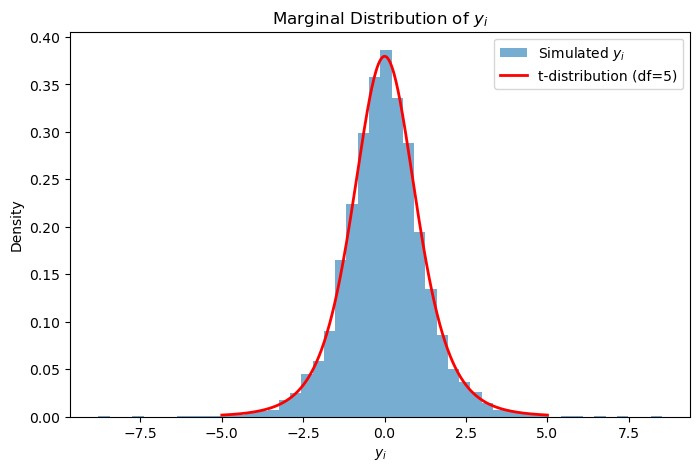

In [26]:
# Set random seed for reproducibility
np.random.seed(123)

# Define parameters
nu = 5  # Degrees of freedom for the gamma and t-distributions
n_samples = 10000

# Step 1: Sample tau_i from Gamma(ν/2, rate=ν/2)
alpha = nu / 2
beta = nu / 2
tau_samples = gamma.rvs(a=alpha, scale=1/beta, size=n_samples)

# Step 2: Sample y_i from N(0, 1/τ_i)
y_samples = norm.rvs(loc=0, scale=1/np.sqrt(tau_samples), size=n_samples)

# Step 3: Plot the histogram of y_samples and overlay a t-distribution
x = np.linspace(-5, 5, 500)
t_pdf = t.pdf(x, df=nu)

plt.figure(figsize=(8, 5))
plt.hist(y_samples, bins=50, density=True, alpha=0.6, label='Simulated $y_i$')
plt.plot(x, t_pdf, 'r-', lw=2, label=f't-distribution (df={nu})')
plt.title("Marginal Distribution of $y_i$")
plt.xlabel("$y_i$")
plt.ylabel("Density")
plt.legend()
plt.show()

### Derivation

We begin with the following two densities:

1. **The conditional density of** \\( y_i \\) **given** \\( \tau_i \\):
   \\[
   p(y_i \mid \tau_i) = \sqrt{\frac{\tau_i}{2\pi}} \exp\left(-\frac{1}{2}\tau_i y_i^2\right),
   \\]
   which is the density of a Normal distribution with mean 0 and variance \\(1/\tau_i\\).

2. **The prior on** \\( \tau_i \\):
   \\[
   p(\tau_i) = \textrm{Gamma}\Big(\tau_i \,\Big|\, \alpha = \frac{\nu}{2},\, \beta = \frac{\nu}{2}\Big) 
   = \frac{\left(\frac{\nu}{2}\right)^{\nu/2}}{\Gamma\left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1} \exp\left(-\frac{\nu}{2}\tau_i\right).
   \\]

Our goal is to integrate out the latent variable \\(\tau_i\\) to obtain the marginal (predictive) density for \\(y_i\\):
\\[
p(y_i) = \int_0^\infty p(y_i\mid \tau_i) \, p(\tau_i) \, d\tau_i.
\\]

Plugging in the expressions we have:
\\[
\begin{aligned}
p(y_i) &= \int_0^\infty \sqrt{\frac{\tau_i}{2\pi}} \exp\left(-\frac{1}{2}\tau_i y_i^2\right)
\frac{\left(\frac{\nu}{2}\right)^{\nu/2}}{\Gamma\left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1} \exp\left(-\frac{\nu}{2}\tau_i\right) d\tau_i\\[1mm]
&= \frac{\left(\frac{\nu}{2}\right)^{\nu/2}}{\Gamma\left(\frac{\nu}{2}\right)\sqrt{2\pi}} \int_0^\infty \tau_i^{\frac{1}{2} + \frac{\nu}{2}-1} \exp\left[-\frac{1}{2}\tau_i \Big(y_i^2 + \nu\Big)\right] d\tau_i.
\end{aligned}
\\]

Notice that the power of \\(\tau_i\\) in the integrand is:
\\[
\frac{1}{2} + \left(\frac{\nu}{2}-1\right) = \frac{\nu+1}{2} - 1.
\]
Thus, we can write:
\[
p(y_i) = \frac{\left(\frac{\nu}{2}\right)^{\nu/2}}{\Gamma\left(\frac{\nu}{2}\right)\sqrt{2\pi}} \int_0^\infty \tau_i^{\frac{\nu+1}{2}-1} \exp\left[-\frac{1}{2}\tau_i \Big(y_i^2 + \nu\Big)\right] d\tau_i.
\\]

Recall that the gamma function is defined by:
\\[
\int_0^\infty \tau^{a-1} e^{-b\tau} d\tau = \frac{\Gamma(a)}{b^a},
\\]
where \\( a > 0 \\) and \\( b > 0 \\). Here, we identify:
- \\( a = \frac{\nu+1}{2} \\),
- \\( b = \frac{y_i^2+\nu}{2} \\).

Thus, the integral evaluates to:
\\[
\int_0^\infty \tau_i^{\frac{\nu+1}{2}-1} \exp\left[-\frac{1}{2}\tau_i \Big(y_i^2+\nu\Big)\right] d\tau_i 
= \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\left(\frac{y_i^2+\nu}{2}\right)^{\frac{\nu+1}{2}}}.
\\]

Substitute this back into our expression for \\( p(y_i) \\):
\\[
\begin{aligned}
p(y_i) &= \frac{\left(\frac{\nu}{2}\right)^{\nu/2}}{\Gamma\left(\frac{\nu}{2}\right)\sqrt{2\pi}} \, \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\left(\frac{y_i^2+\nu}{2}\right)^{\frac{\nu+1}{2}}} \\[1mm]
&= \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)\sqrt{2\pi}} \, \left(\frac{\nu}{2}\right)^{\nu/2} \, \left(\frac{2}{y_i^2+\nu}\right)^{\frac{\nu+1}{2}}.
\end{aligned}
\\]

Let us combine the constants:
\\[
\left(\frac{\nu}{2}\right)^{\nu/2} \left(\frac{2}{y_i^2+\nu}\right)^{\frac{\nu+1}{2}}
= \nu^{\nu/2} \, 2^{1/2} \, \frac{1}{(y_i^2+\nu)^{\frac{\nu+1}{2}}}.
\\]
Then, combining with the factor \\(1/\sqrt{2\pi}\\):
\\[
\frac{2^{1/2}}{\sqrt{2\pi}} = \frac{1}{\sqrt{\pi}},
\\]
so that
\\[
p(y_i) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)} \frac{\nu^{\nu/2}}{\sqrt{\pi}(y_i^2+\nu)^{\frac{\nu+1}{2}}}.
\\]

This is exactly the density of a **Student's t distribution** with \\(\nu\\) degrees of freedom, location 0, and a scale parameter equal to 1. That is,
\\[
p(y_i) = t_{\nu}(y_i).
\\]

---

### Relevance to Predictive Posterior Distributions

The derivation above demonstrates that when we **integrate out uncertainty** in the latent precision parameter \\( \tau_i \\) (which is given a Gamma prior), the resulting marginal distribution for \\( y_i \\) is a Student's t distribution. This procedure is analogous to obtaining a **predictive posterior distribution** in Bayesian analysis.

In Bayesian inference, the posterior predictive distribution for a new observation \\( \tilde{y} \\) is given by
\\[
p(\tilde{y}\mid y) = \int p(\tilde{y} \mid \theta) \, p(\theta \mid y) \, d\theta,
\\]
where \\( p(\theta \mid y) \\) is the posterior distribution of the model parameters after observing the data \\( y \\). Here, by integrating out \\( \tau_i \\) (which plays the role of a model parameter or latent variable), we obtain the marginal distribution for \\( y_i \\) that fully reflects the uncertainty in \\( \tau_i \\).

This mixture-of-normals interpretation (with the mixing distribution being Gamma) is well known to lead to a heavy-tailed Student's t distribution. In predictive modeling, such heavy-tailed behavior is desirable when the data may contain outliers or when there is uncertainty in the variance. The t distribution automatically provides more robust predictions compared to a normal distribution because its heavier tails assign higher probability to extreme values.

Thus, this derivation not only provides an explicit calculation showing that a Gamma–Normal mixture yields a Student’s t density for \\( y_i \\), but it also illustrates the general Bayesian principle of **marginalization**—integrating out latent parameters to obtain a predictive distribution that accounts for all sources of uncertainty.

---

This complete derivation and explanation demonstrate how the integration over a latent variable leads to a robust predictive distribution, which is central to Bayesian predictive inference.
